In this notebook you will find the implementation of MCMC for the smiley-frowny Gaussian noise data.

# Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import cv2
from datetime import date

from scipy.stats import gaussian_kde, mode
import matplotlib.tri as tri
from sklearn.metrics import mean_squared_error, mean_absolute_error

import emcee
import corner

# Load Data

Here we load the smiley-frowny test set with $m = 100\times10^3,\ n=20, \sigma_0 = 0.5$ and $\Delta g = 0.5$ and select only the $50\times10^3$ smiley objects to perform MCMC.

In [7]:
# Load test set
test = pd.read_csv('smileyfrowny/datasets/test_m100_n20_sig5_dg5.csv')

# Get smileys only
test = test[test['type'] == 1]

# Settings

This section performs MCMC in individual objects to set the parameters:


*   nwalkers: number of walkers
*   nsteps: number of steps each walker takes
*   burn: number of steps (per walker) to be discarded
*   prior limits to each parameter



In [14]:
dataset = test
n = 20

# MCMC parameters
ndim = 3
nwalkers = 10
nsteps = 2000
burn = 200

In [15]:
def parabola(theta):

  i = np.arange(1, 21)

  smiley = theta[0] * (i/n)**2 + theta[1] * (i/n) + theta[2]

  return smiley

# Data: select a curve
data = np.array(dataset.iloc[0, :n])
err  = np.array(dataset.iloc[0, n:2*n])

# Choose limits
a_l = -3.0
a_r =  3.0

b_l = -5.0
b_r =  5.0

c_l = -5.0
c_r = 25.0


def like_prior(theta):

  if not(a_l < theta[0] < a_r and
         b_l < theta[1] < b_r and
         c_l < theta[2] < c_r):
    
    return -np.inf

  diff = data - parabola(theta)
  
  return -0.5 * np.sum((diff / err)**2)

pos = np.zeros((nwalkers, ndim))
pos[:, 0] = np.random.uniform(low=a_l, high=a_r, size=(nwalkers))
pos[:, 1] = np.random.uniform(low=b_l, high=b_r, size=(nwalkers))
pos[:, 2] = np.random.uniform(low=c_l, high=c_r, size=(nwalkers))

sampler = emcee.EnsembleSampler(nwalkers, ndim, like_prior)

## Run MCMC

In [16]:
# Run
start = time.perf_counter()

sampler.run_mcmc(pos, nsteps, progress=True)

elapsed = time.perf_counter() - start
print('Elapsed %.3f seconds.' % elapsed)

100%|██████████| 2000/2000 [00:01<00:00, 1273.03it/s]

Elapsed 1.583 seconds.


## Chain Plots

It is useful to evaluate the convergence of the chains to choose an appropriate burn-in number of steps.

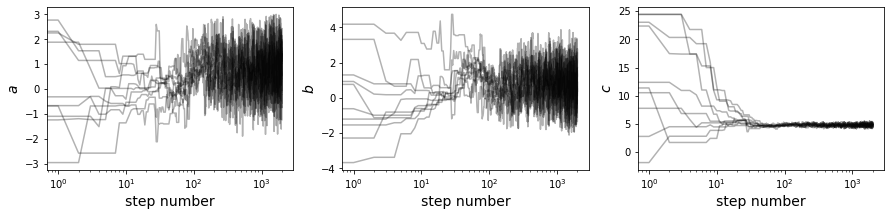

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].plot(sampler.get_chain()[:, :, 0], "k", alpha=0.3)
ax[0].set_xscale('log')

ax[0].set_xlabel('step number', fontsize=14)
ax[0].set_ylabel('$a$', fontsize=14)

ax[1].plot(sampler.get_chain()[:, :, 1], "k", alpha=0.3)
ax[1].set_xscale('log')

ax[1].set_xlabel('step number', fontsize=14)
ax[1].set_ylabel('$b$', fontsize=14)

ax[2].plot(sampler.get_chain()[:, :, 2], "k", alpha=0.3)
ax[2].set_xscale('log')

ax[2].set_xlabel('step number', fontsize=14)
ax[2].set_ylabel('$c$', fontsize=14)

plt.show()

## Triangle Plots



Probability of being smiley:  0.8407222222222223


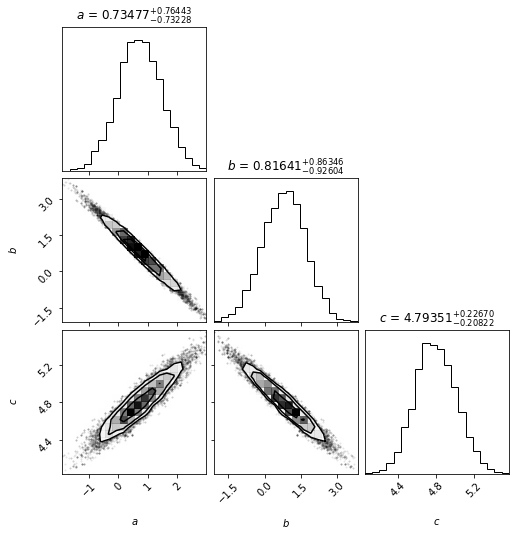

In [18]:
# Triangle
flat_samples = sampler.get_chain(discard=burn, thin=1, flat=True)

prob_smiley = np.sum(flat_samples[:, 0] > 0) / ((nsteps - burn) * nwalkers)
print('Probability of being smiley: ', prob_smiley)

labels = ['$a$', '$b$', '$c$']
fig = corner.corner(flat_samples, labels=labels, 
                    show_titles=True, title_fmt='.5f')